<a href="https://colab.research.google.com/github/ashutosh7i/VoiceVibeAI/blob/main/backend/tfidfSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# feature extraction / vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# save and load a file
import pickle

In [ ]:
df_train = pd.read_csv('/content/data_train.csv')
df_test = pd.read_csv('/content/data_test.csv')

X_train = df_train.Text
X_test = df_test.Text

y_train = df_train.Emotion
y_test = df_test.Emotion

class_names = ['joy', 'sadness', 'anger', 'neutral', 'fear']
data = pd.concat([df_train, df_test])

print('size of training set: %s' % (len(df_train['Text'])))
print('size of validation set: %s' % (len(df_test['Text'])))
print(data.Emotion.value_counts())

data.head()

size of training set: 7934
size of validation set: 3393
Emotion
joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: count, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...


In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [ ]:
def preprocess_and_tokenize(data):

    #remove html markup
    data = re.sub("(<.*?>)", "", data)

    #remove urls
    data = re.sub(r'http\S+', '', data)

    #remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    #remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)

    #remove whitespace
    data = data.strip()

    # tokenization with nltk
    data = word_tokenize(data)

    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]

    return stem_data

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# fit on our complete corpus
vect.fit_transform(data.Text)

# transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Accuracy: 67.02%

F1 Score: 67.02

COnfusion Matrix:
 [[469  32  44  28 120]
 [ 73 420  55  16 115]
 [ 56  18 475  68  90]
 [ 61  20  76 385  96]
 [ 68  20  48  15 525]]


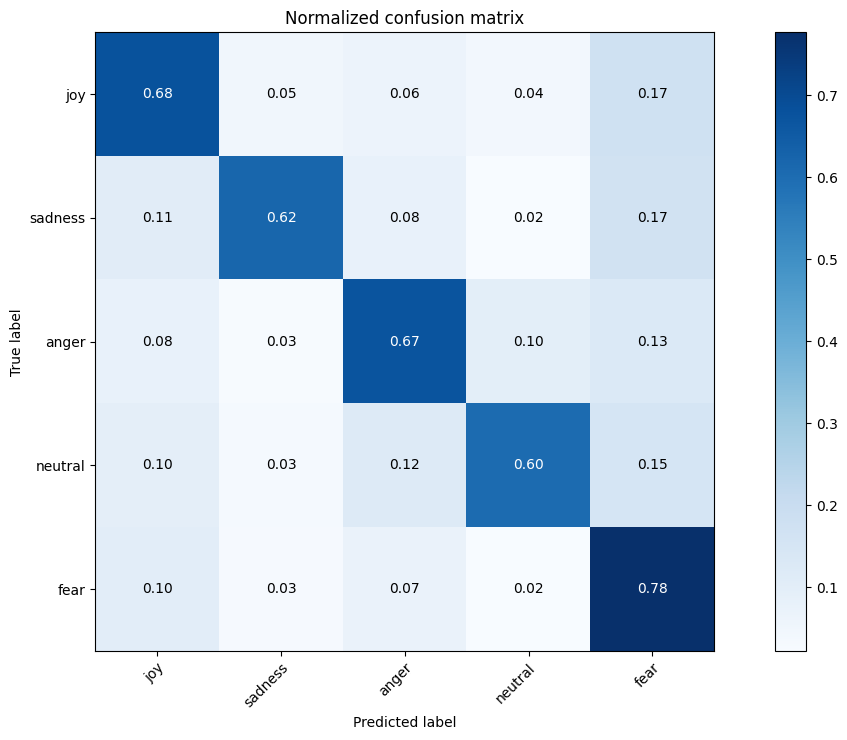

In [ ]:
nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 64.43%

F1 Score: 64.43

COnfusion Matrix:
 [[408  70  49  91  75]
 [ 88 435  54  61  41]
 [ 70  52 440 105  40]
 [ 43  24  33 518  20]
 [ 98  62  76  55 385]]


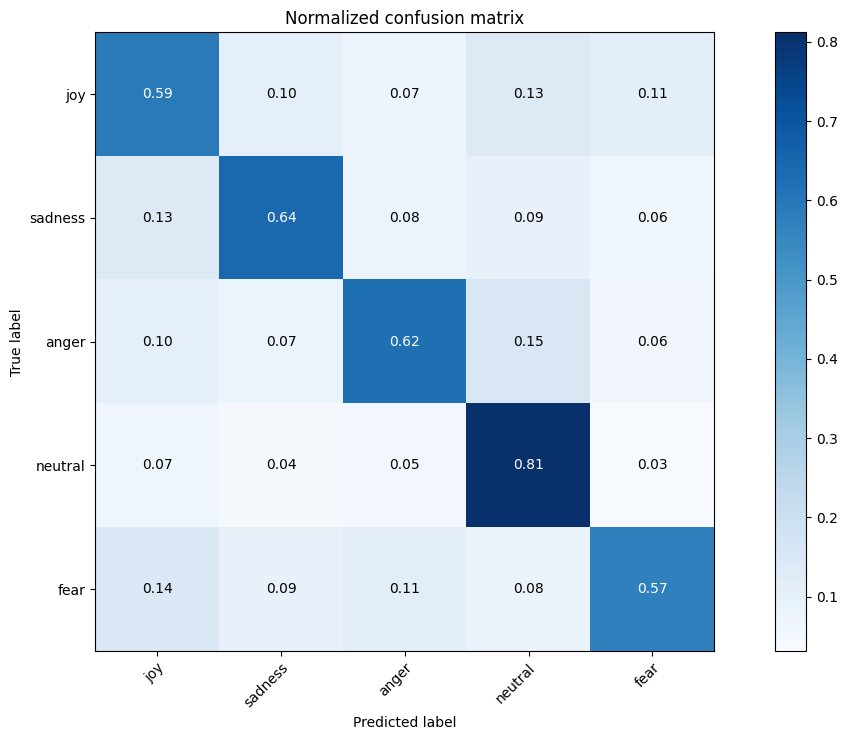

In [ ]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 69.35%

F1 Score: 69.35

COnfusion Matrix:
 [[456  67  44  68  58]
 [ 65 483  42  50  39]
 [ 56  34 476 101  40]
 [ 41  23  42 498  34]
 [ 82  60  51  43 440]]


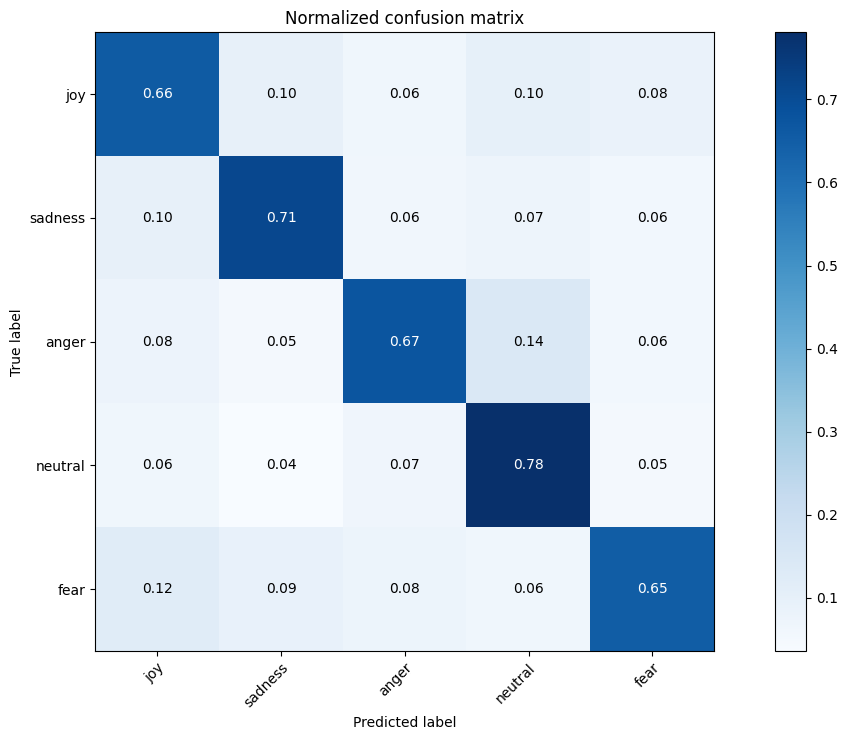

In [ ]:
log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Accuracy: 72.71%

F1 Score: 72.71

COnfusion Matrix:
 [[490  49  41  58  55]
 [ 53 508  34  40  44]
 [ 50  33 498  91  35]
 [ 34  23  38 505  38]
 [ 72  43  53  42 466]]


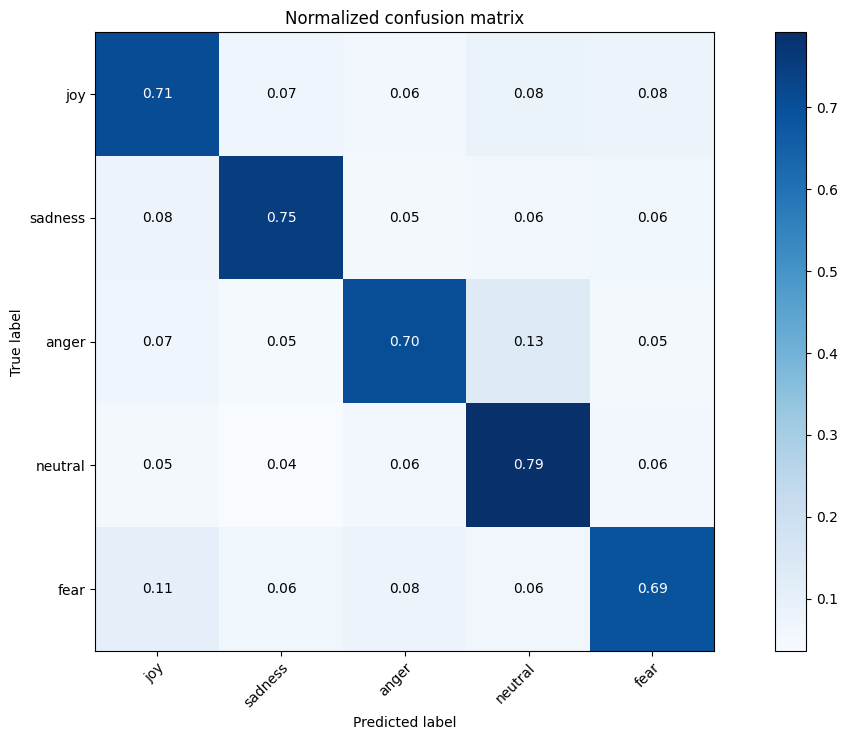

In [ ]:
svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nCOnfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [ ]:
#Create pipeline with our tf-idf vectorizer and LinearSVC model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])
# save the model
filename = 'models/tfidf_svm.sav'
!mkdir models # create the models directory
pickle.dump(svm_model, open(filename, 'wb'))
model = pickle.load(open(filename, 'rb'))

message = 'delivery was hour late and my pizza is cold!'
model.predict([message])

mkdir: cannot create directory ‘models’: File exists


array(['anger'], dtype=object)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>